# Mortality prediction post micro-biology result patients using EHR data without QC - XGBoost

## Read data matrix

In [44]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_no_qc;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


## Test/Train split

In [45]:
X = dataDf.drop(['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'onetwenty_day_mortality'], axis = 1)
y_seven_day = dataDf['seven_day_mortality']
y_fourteen_day = dataDf['fourteen_day_mortality']
y_twentyone_day = dataDf['twentyone_day_mortality']
y_twentyeight_day = dataDf['twentyeight_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']
y_onetwenty_day = dataDf['onetwenty_day_mortality']

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_seven_day_train, y_seven_day_test, y_fourteen_day_train, y_fourteen_day_test, y_twentyone_day_train, y_twentyone_day_test, y_twentyeight_day_train, y_twentyeight_day_test, y_sixty_day_train, y_sixty_day_test, y_ninety_day_train, y_ninety_day_test, y_onetwenty_day_train, y_onetwenty_day_test = train_test_split(X, y_seven_day, y_fourteen_day, y_twentyone_day, y_twentyeight_day, y_sixty_day, y_ninety_day, y_onetwenty_day, test_size=0.2, random_state=42)

In [47]:
X_train.shape, X_test.shape

((5681, 159), (1421, 159))

In [48]:
y_seven_day_train.shape, y_seven_day_test.shape

((5681,), (1421,))

In [49]:
y_fourteen_day_train.shape, y_fourteen_day_test.shape

((5681,), (1421,))

In [50]:
y_twentyone_day_train.shape, y_twentyone_day_test.shape

((5681,), (1421,))

In [51]:
y_twentyeight_day_train.shape, y_twentyeight_day_test.shape

((5681,), (1421,))

In [52]:
y_sixty_day_train.shape, y_sixty_day_test.shape

((5681,), (1421,))

In [53]:
y_ninety_day_train.shape, y_ninety_day_test.shape

((5681,), (1421,))

In [54]:
y_onetwenty_day_train.shape, y_onetwenty_day_test.shape

((5681,), (1421,))

## Machine Learning using XGBoost

In [55]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Seven-day mortality prediction

In [56]:
xgb_seven_day = XGBClassifier()
xgb_seven_day.fit(X_train, y_seven_day_train)
y_seven_day_pred = xgb_seven_day.predict(X_test)
y_seven_day_prob = xgb_seven_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 143 artists>

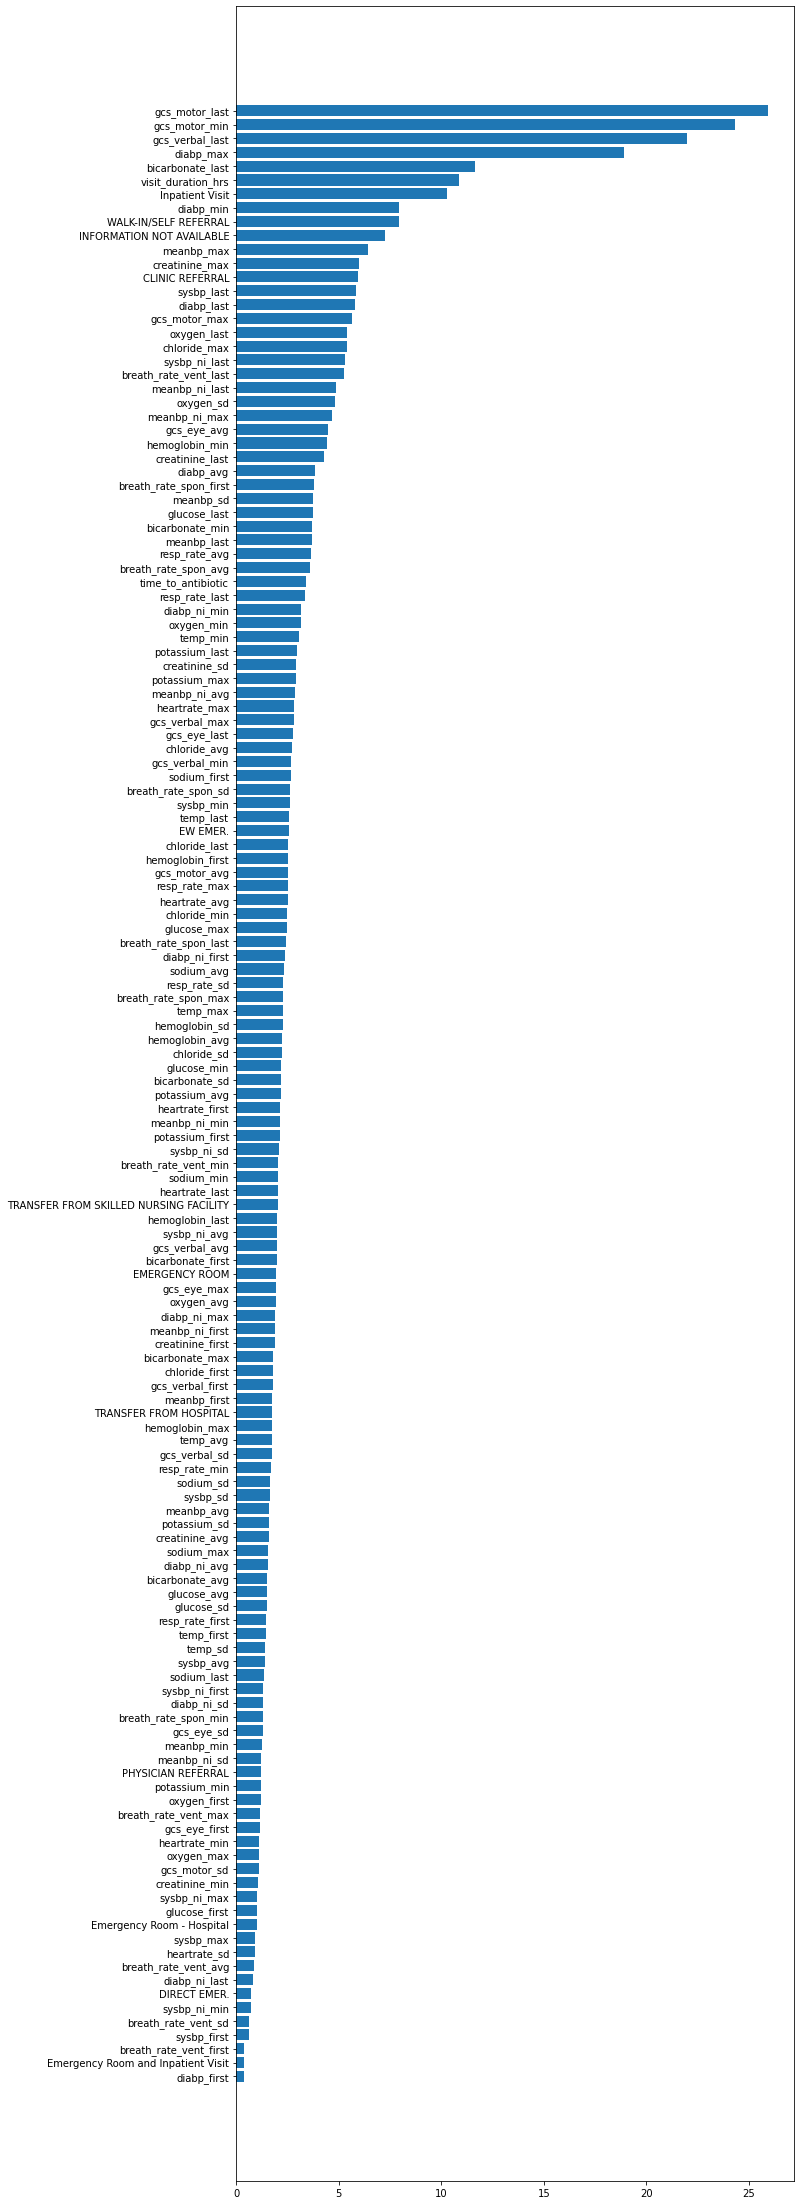

In [57]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_seven_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Fourteen-day mortality prediction

In [58]:
xgb_fourteen_day = XGBClassifier()
xgb_fourteen_day.fit(X_train, y_fourteen_day_train)
y_fourteen_day_pred = xgb_fourteen_day.predict(X_test)
y_fourteen_day_prob = xgb_fourteen_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 142 artists>

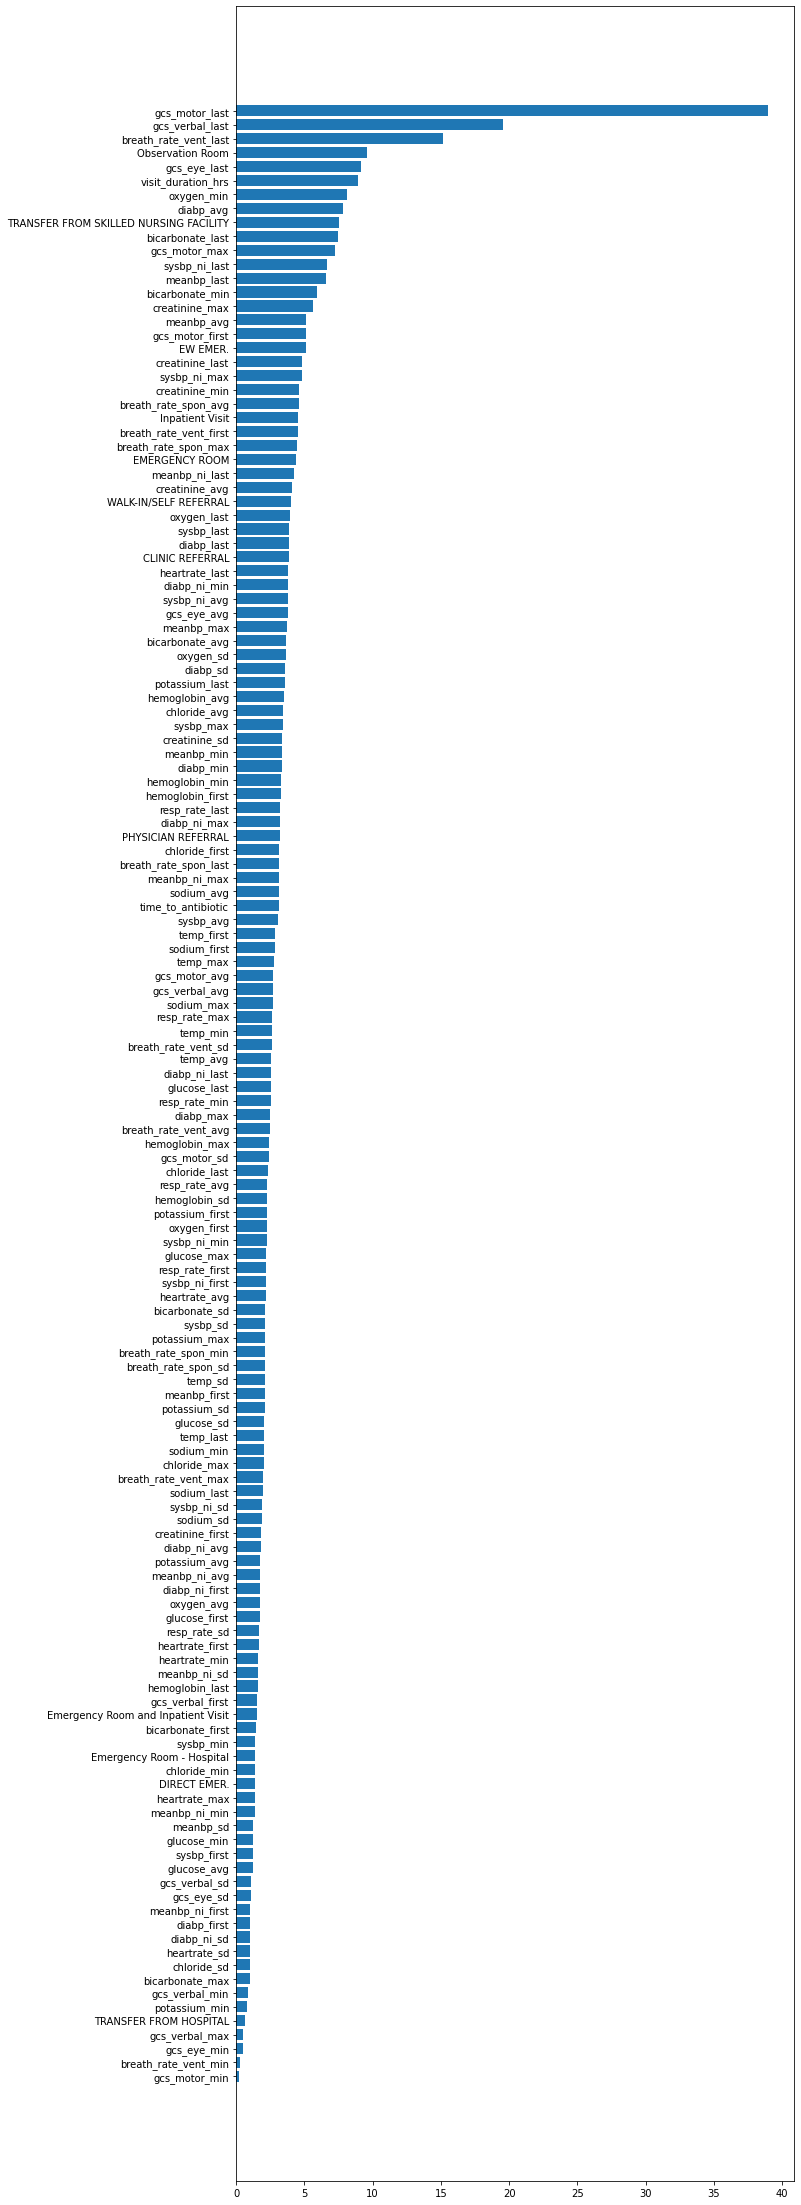

In [59]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_fourteen_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Twentyone-day mortality prediction

In [60]:
xgb_twentyone_day = XGBClassifier()
xgb_twentyone_day.fit(X_train, y_twentyone_day_train)
y_twentyone_day_pred = xgb_twentyone_day.predict(X_test)
y_twentyone_day_prob = xgb_twentyone_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 145 artists>

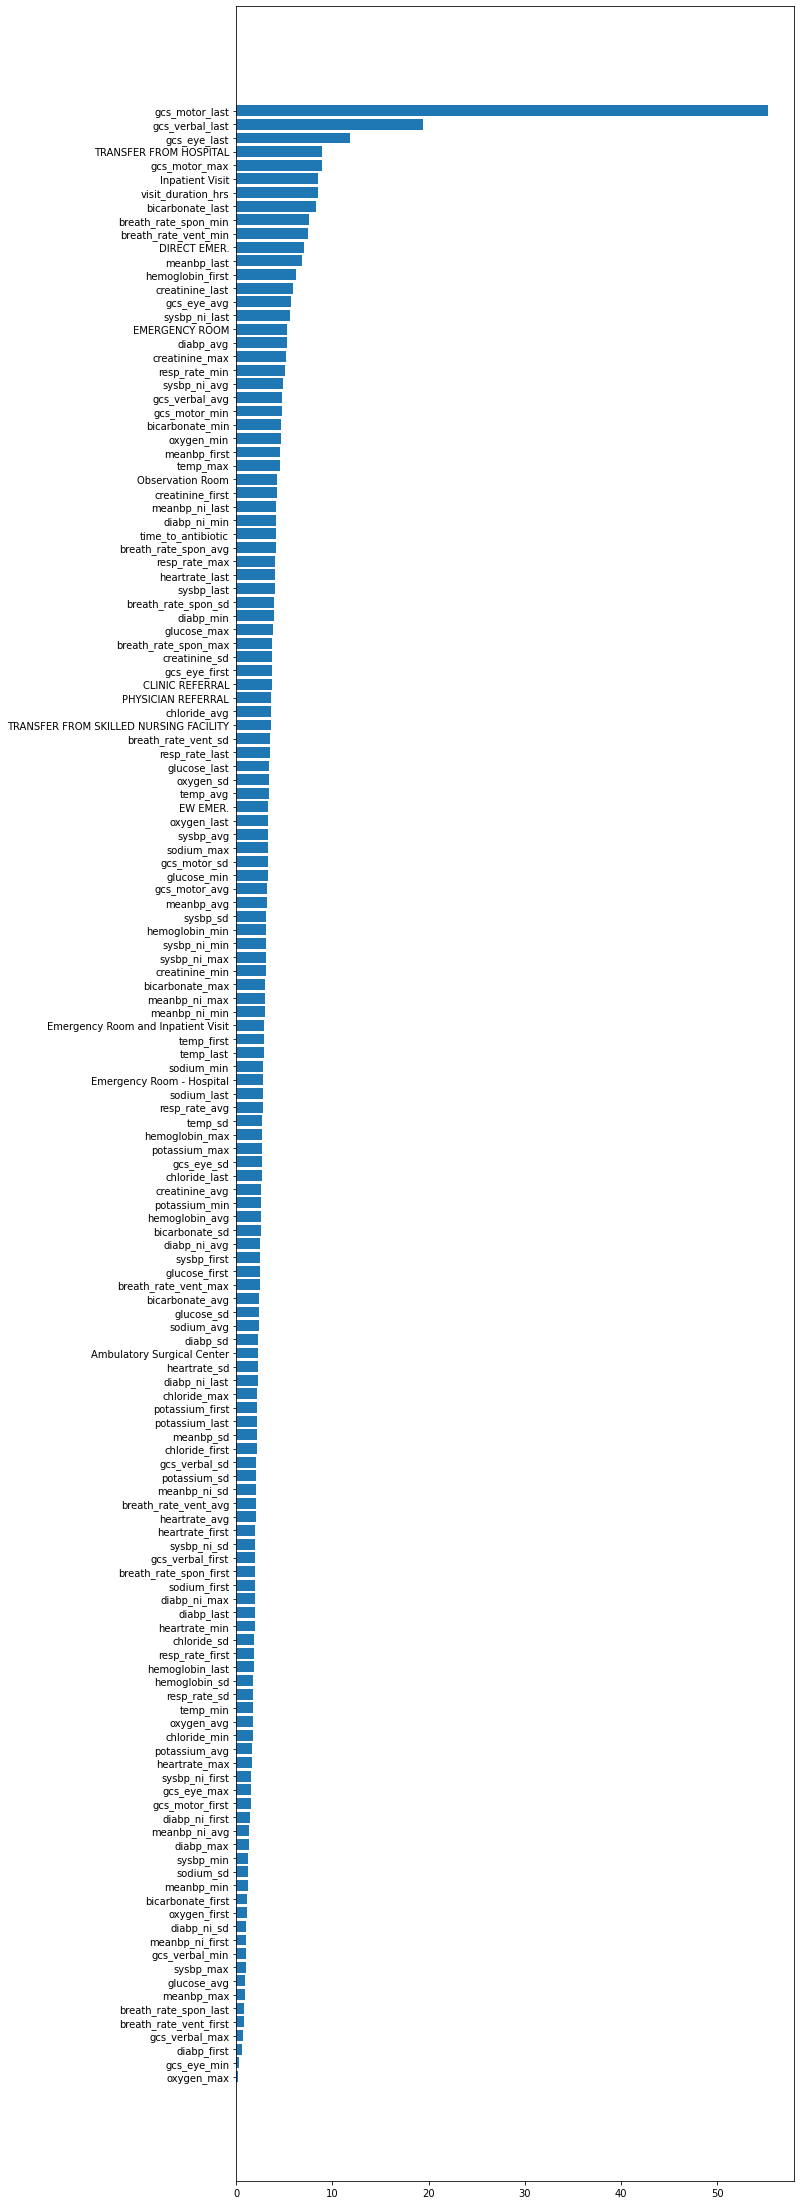

In [61]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_twentyone_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Twentyeight-day mortality prediction

In [62]:
xgb_twentyeight_day = XGBClassifier()
xgb_twentyeight_day.fit(X_train, y_twentyeight_day_train)
y_twentyeight_day_pred = xgb_twentyeight_day.predict(X_test)
y_twentyeight_day_prob = xgb_twentyeight_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 146 artists>

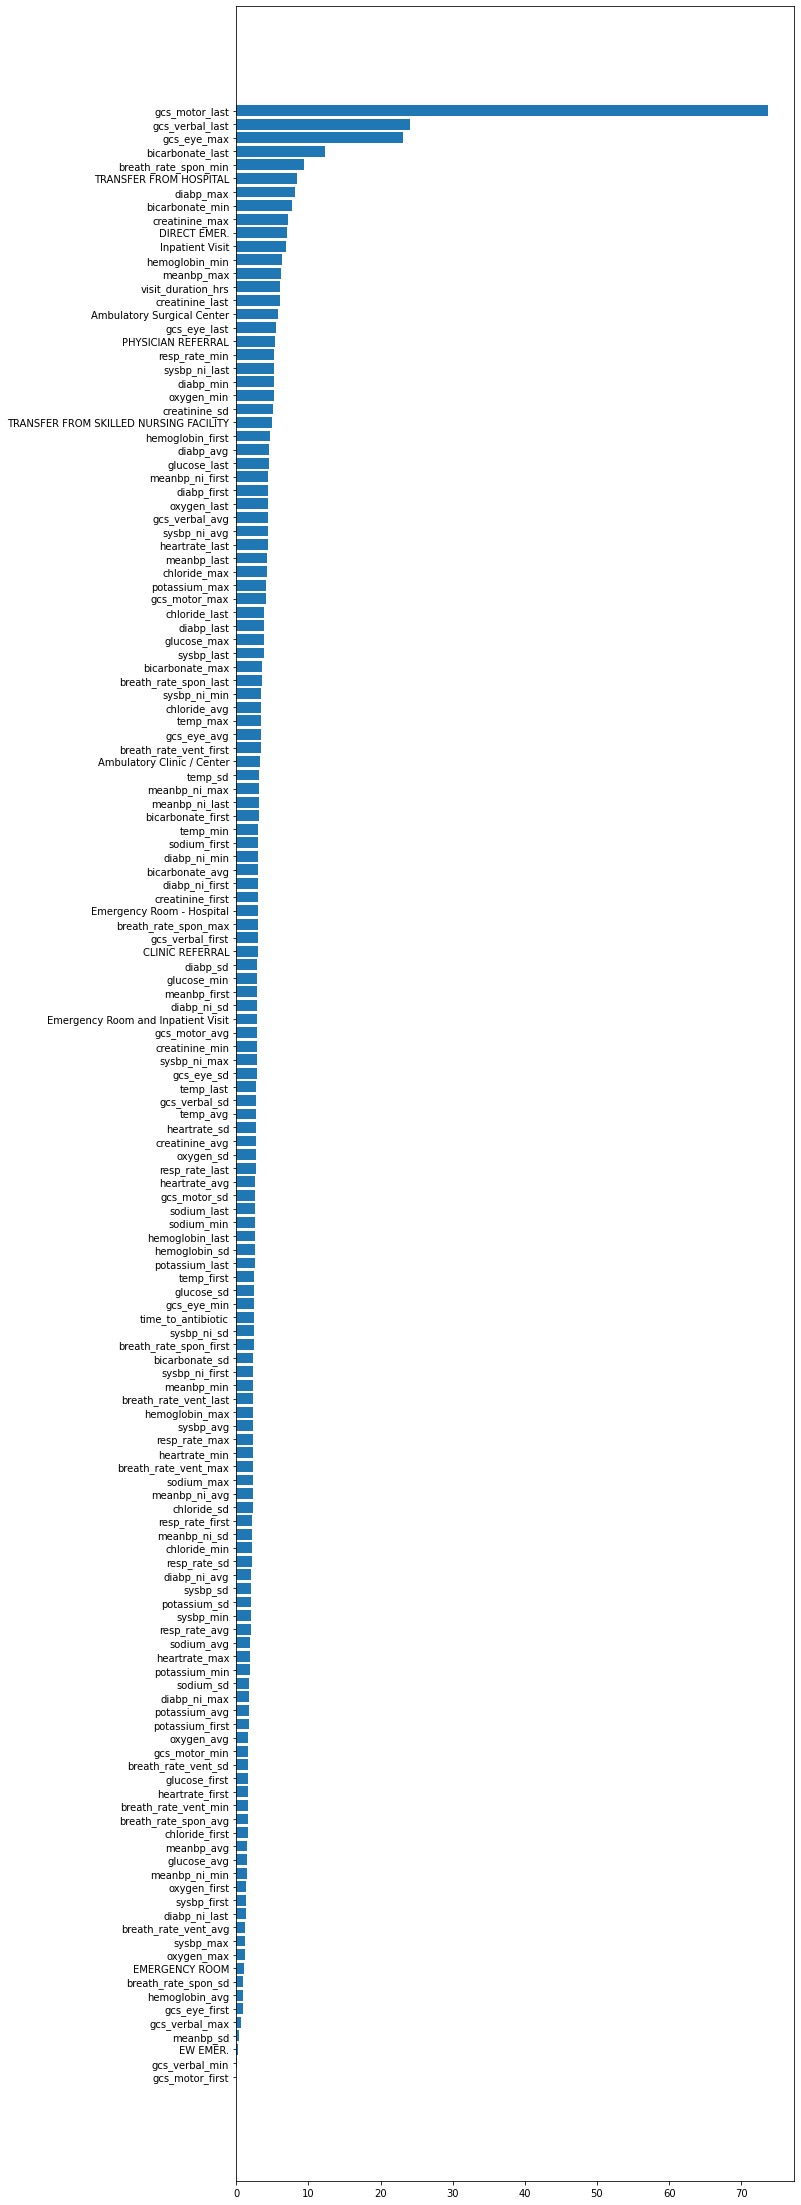

In [63]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_twentyeight_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Sixty-day mortality prediction

In [64]:
xgb_sixty_day = XGBClassifier()
xgb_sixty_day.fit(X_train, y_sixty_day_train)
y_sixty_day_pred = xgb_sixty_day.predict(X_test)
y_sixty_day_prob = xgb_sixty_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 146 artists>

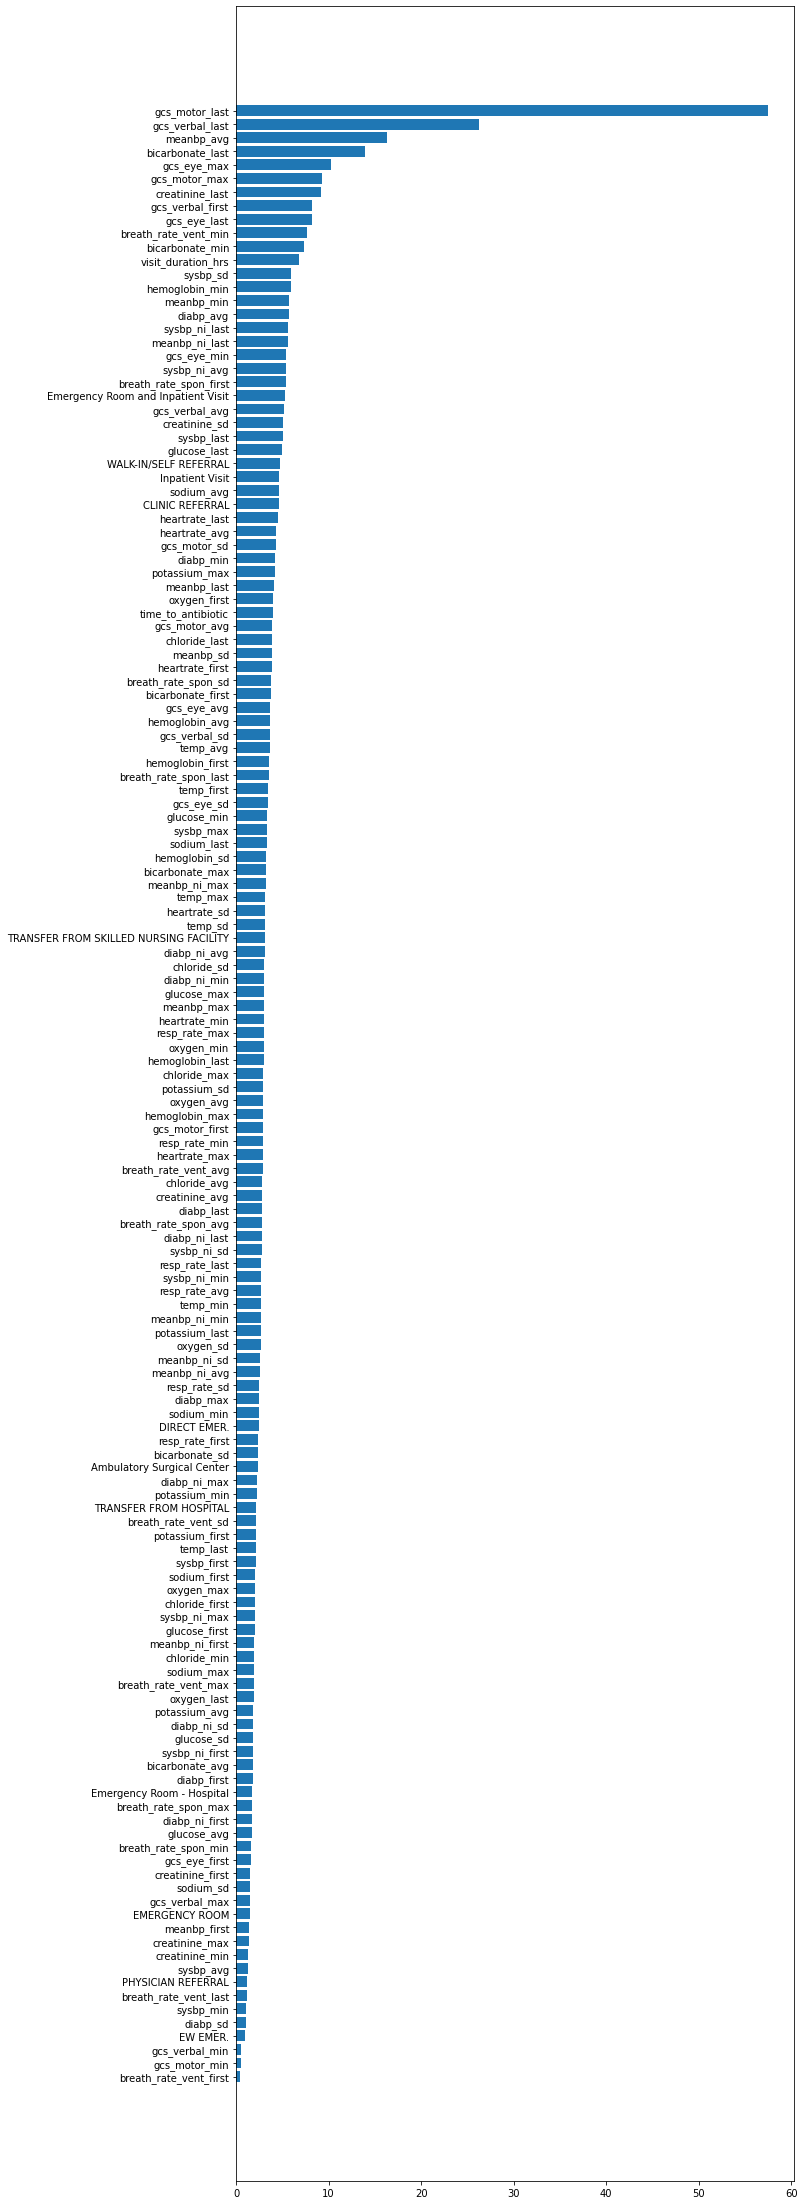

In [65]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_sixty_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Ninety-day mortality prediction

In [66]:
xgb_ninety_day = XGBClassifier()
xgb_ninety_day.fit(X_train, y_ninety_day_train)
y_ninety_day_pred = xgb_ninety_day.predict(X_test)
y_ninety_day_prob = xgb_ninety_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 144 artists>

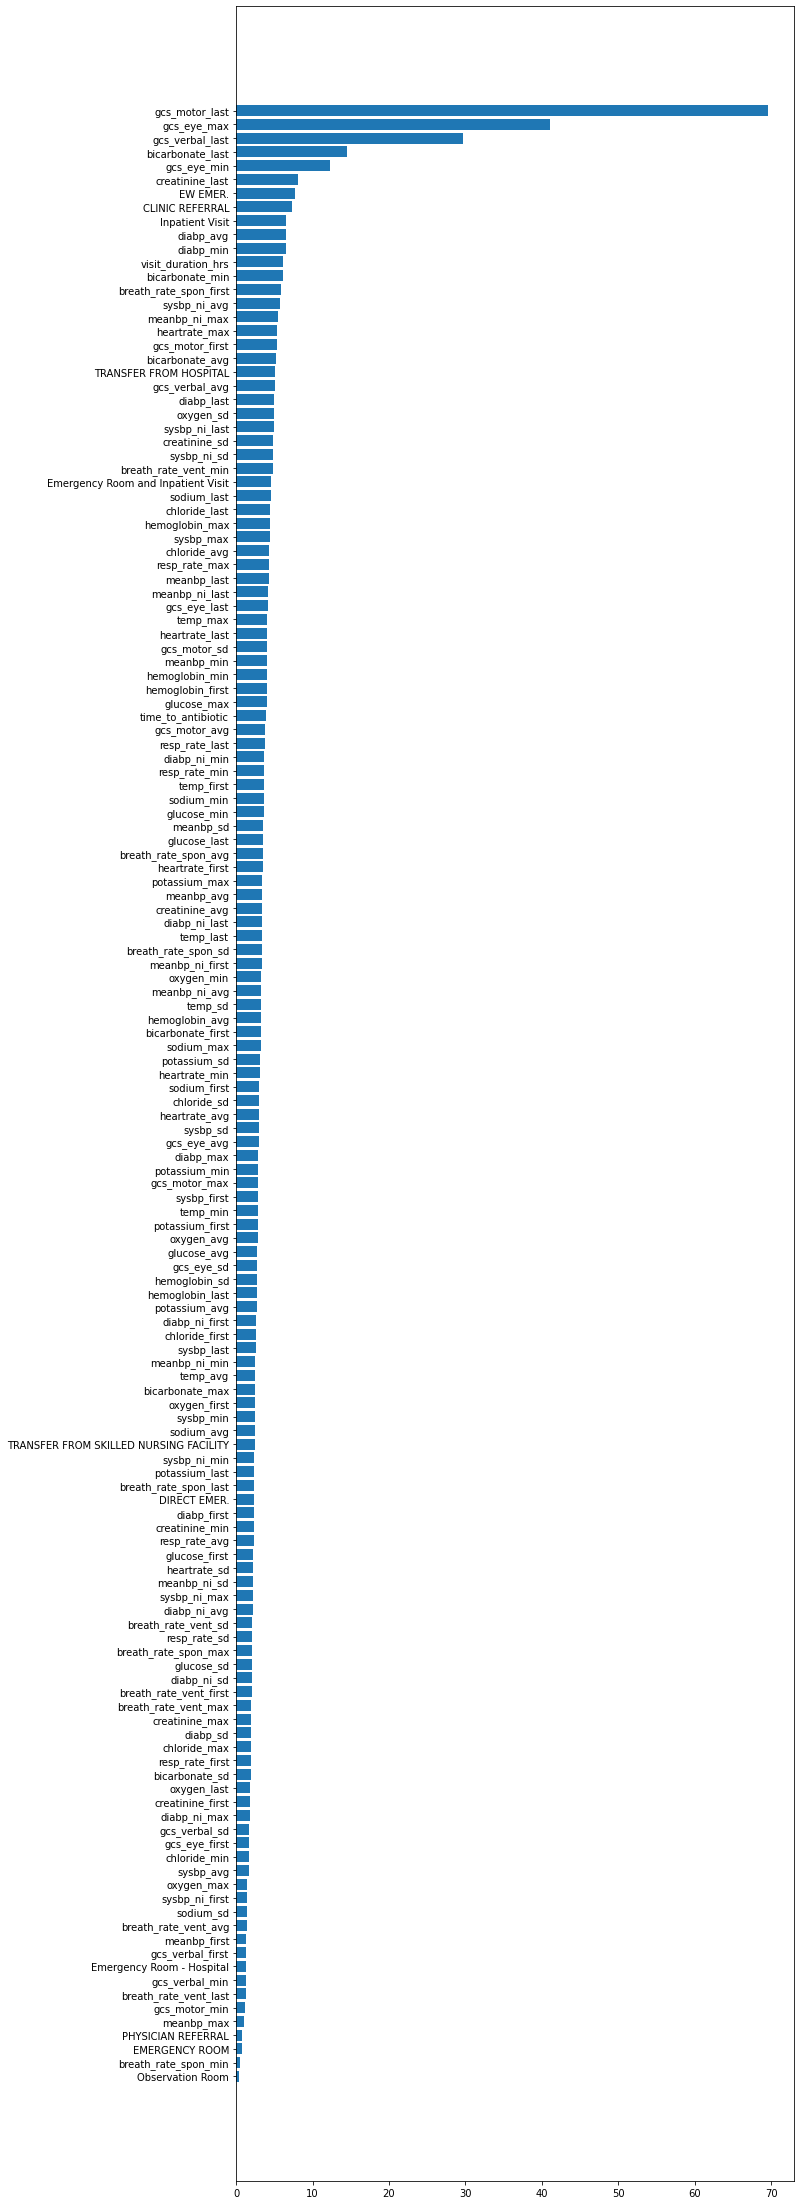

In [67]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_ninety_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Onetwenty-day mortality prediction

In [68]:
xgb_onetwenty_day = XGBClassifier()
xgb_onetwenty_day.fit(X_train, y_onetwenty_day_train)
y_onetwenty_day_pred = xgb_onetwenty_day.predict(X_test)
y_onetwenty_day_prob = xgb_onetwenty_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 146 artists>

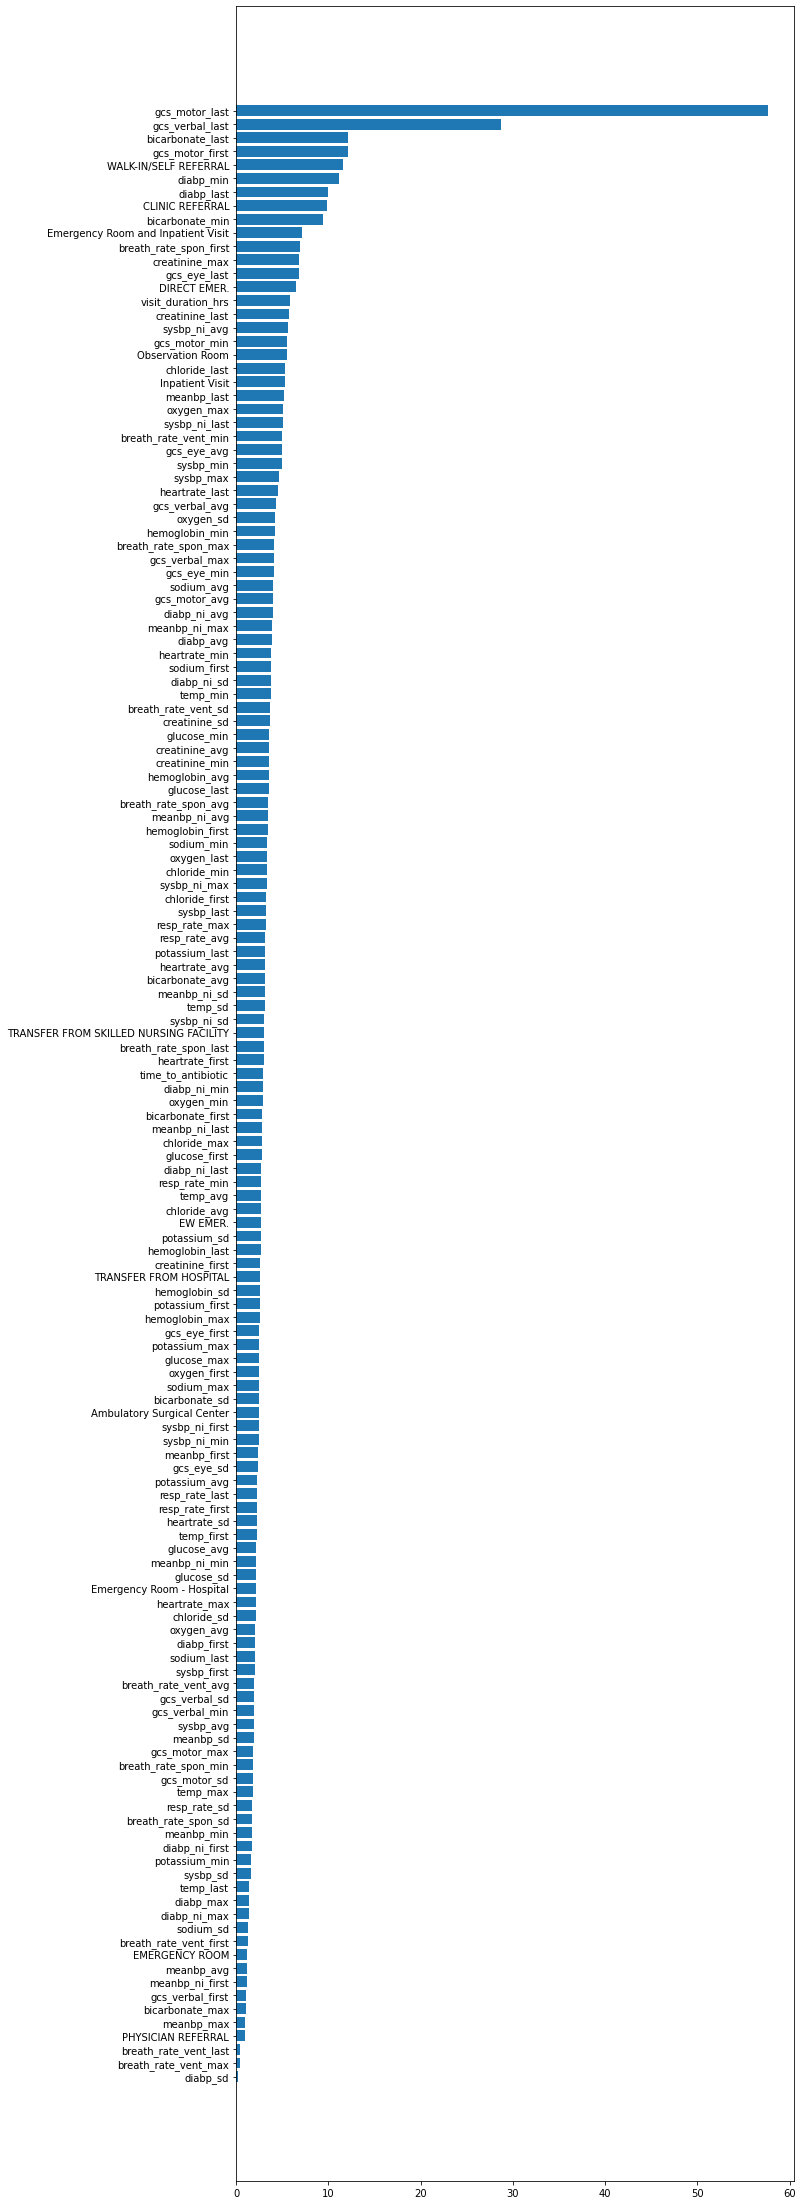

In [69]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_onetwenty_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Performance metrics

#### Accuracy

In [70]:
from sklearn.metrics import accuracy_score

print('Seven day mortality accuracy: ', str(accuracy_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality accuracy: ', str(accuracy_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality accuracy: ', str(accuracy_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality accuracy: ', str(accuracy_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality accuracy: ', str(accuracy_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality accuracy: ', str(accuracy_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality accuracy: ', str(accuracy_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality accuracy:  0.9648135116115412
Fourteen day mortality accuracy:  0.9472202674173118
Twentyone day mortality accuracy:  0.94018296973962
Twentyeight day mortality accuracy:  0.9303307529908516
Sixty day mortality accuracy:  0.9141449683321604
Ninety day mortality accuracy:  0.9085151301900071
Onetwenty day mortality accuracy:  0.9197748064743139


#### F1 score

In [71]:
from sklearn.metrics import f1_score

print('Seven day mortality F1: ', str(f1_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(f1_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(f1_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(f1_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(f1_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(f1_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(f1_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality F1:  0.8704663212435233
Fourteen day mortality F1:  0.8613678373382624
Twentyone day mortality F1:  0.8639999999999999
Twentyeight day mortality F1:  0.8493150684931506
Sixty day mortality F1:  0.8337874659400545
Ninety day mortality F1:  0.8293963254593176
Onetwenty day mortality F1:  0.8553299492385786


#### Matthews Correlation Coefficient

In [72]:
from sklearn.metrics import matthews_corrcoef

print('Seven day mortality F1: ', str(matthews_corrcoef(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(matthews_corrcoef(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(matthews_corrcoef(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(matthews_corrcoef(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(matthews_corrcoef(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(matthews_corrcoef(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(matthews_corrcoef(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality F1:  0.853703137285206
Fourteen day mortality F1:  0.8338739286465212
Twentyone day mortality F1:  0.82769193924232
Twentyeight day mortality F1:  0.807180806560486
Sixty day mortality F1:  0.7795580630655308
Ninety day mortality F1:  0.7712392487947805
Onetwenty day mortality F1:  0.8029619308417048


#### ROC AUC score

In [ ]:
from sklearn.metrics import roc_auc_score

print('Seven day mortality F1: ', str(roc_auc_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(roc_auc_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(roc_auc_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(roc_auc_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(roc_auc_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(roc_auc_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(roc_auc_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

In [73]:
from sklearn.metrics import roc_auc_score

print('Seven day mortality F1: ', str(roc_auc_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(roc_auc_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(roc_auc_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(roc_auc_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(roc_auc_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(roc_auc_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(roc_auc_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality F1:  0.9558200077738708
Fourteen day mortality F1:  0.9456803619584935
Twentyone day mortality F1:  0.929858858858859
Twentyeight day mortality F1:  0.9225302487149047
Sixty day mortality F1:  0.9075167065021219
Ninety day mortality F1:  0.9040527421459719
Onetwenty day mortality F1:  0.9168706765757194


#### Confusion matrix

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

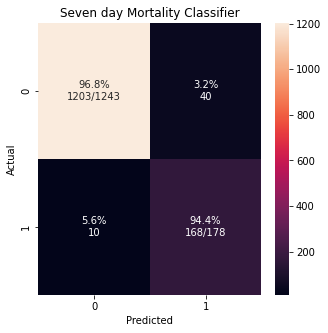

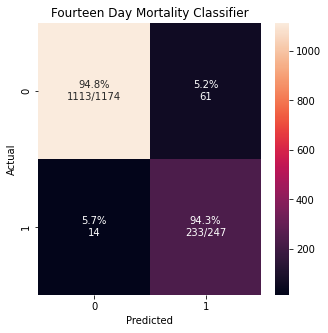

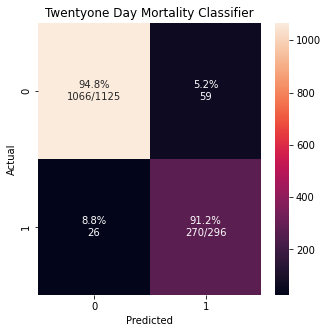

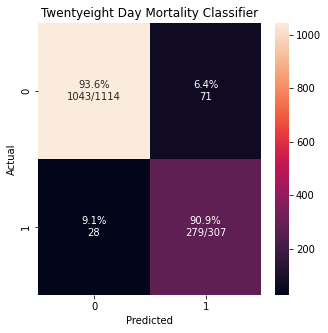

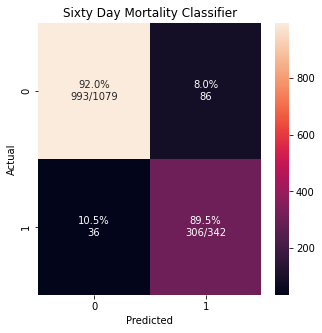

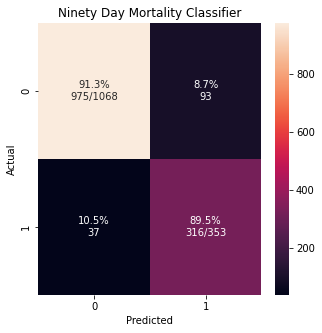

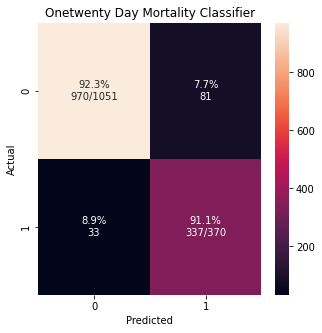

In [75]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_seven_day_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven day Mortality Classifier')

cm_analysis(y_fourteen_day_pred, y_fourteen_day_test, labels, ymap=None, figsize=(5, 5), title='Fourteen Day Mortality Classifier')

cm_analysis(y_twentyone_day_pred, y_twentyone_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyone Day Mortality Classifier')

cm_analysis(y_twentyeight_day_pred, y_twentyeight_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyeight Day Mortality Classifier')

cm_analysis(y_sixty_day_pred, y_sixty_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty Day Mortality Classifier')

cm_analysis(y_ninety_day_pred, y_ninety_day_test, labels, ymap=None, figsize=(5, 5), title='Ninety Day Mortality Classifier')

cm_analysis(y_onetwenty_day_pred, y_onetwenty_day_test, labels, ymap=None, figsize=(5, 5), title='Onetwenty Day Mortality Classifier')

#### ROC curve

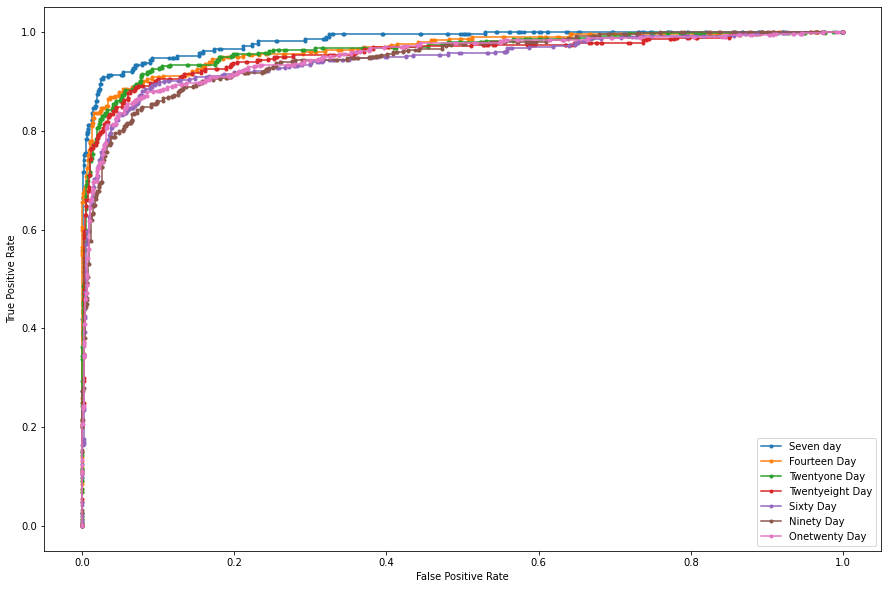

In [87]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_seven_day_test, y_seven_day_prob, 'Seven day')
        , (y_fourteen_day_test, y_fourteen_day_prob, 'Fourteen Day')
        , (y_twentyone_day_test, y_twentyone_day_prob, 'Twentyone Day')
        , (y_twentyeight_day_test, y_twentyeight_day_prob, 'Twentyeight Day')
        , (y_sixty_day_test, y_sixty_day_prob, 'Sixty Day')
        , (y_ninety_day_test, y_ninety_day_prob, 'Ninety Day')
        , (y_onetwenty_day_test, y_onetwenty_day_prob, 'Onetwenty Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### PRC curve

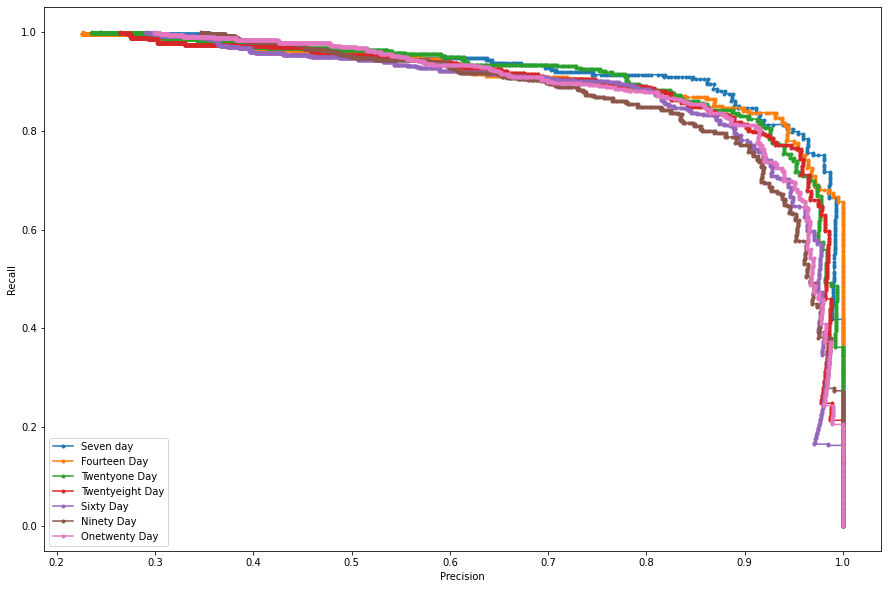

In [108]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_seven_day_test, [p2 for p1, p2 in y_seven_day_prob], 'Seven day')
        , (y_fourteen_day_test, [p2 for p1, p2 in y_fourteen_day_prob], 'Fourteen Day')
        , (y_twentyone_day_test, [p2 for p1, p2 in y_twentyone_day_prob], 'Twentyone Day')
        , (y_twentyeight_day_test, [p2 for p1, p2 in y_twentyeight_day_prob], 'Twentyeight Day')
        , (y_sixty_day_test, [p2 for p1, p2 in y_sixty_day_prob], 'Sixty Day')
        , (y_ninety_day_test, [p2 for p1, p2 in y_ninety_day_prob], 'Ninety Day')
        , (y_onetwenty_day_test, [p2 for p1, p2 in y_onetwenty_day_prob], 'Onetwenty Day')
    ]:
    precision, recall, thresholds = precision_recall_curve(test, prob)
    plt.plot(precision, recall, marker='.', label=label)

# axis labels
plt.xlabel('Precision')
plt.ylabel('Recall')
# show the legend
plt.legend()
# show the plot
plt.show()

### MCC F1

In [35]:
from mcc_f1 import plot_mcc_f1_curve

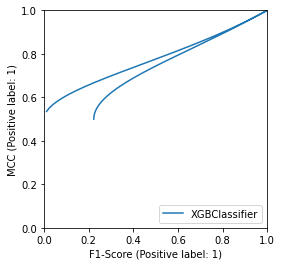

In [36]:
plot_mcc_f1_curve(xgb_seven_day, X_test, y_seven_day_pred)

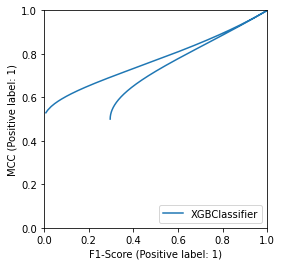

In [37]:
plot_mcc_f1_curve(xgb_fourteen_day, X_test, y_fourteen_day_pred)

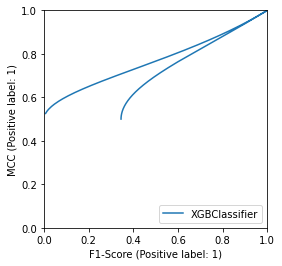

In [38]:
plot_mcc_f1_curve(xgb_twentyone_day, X_test, y_twentyone_day_pred)

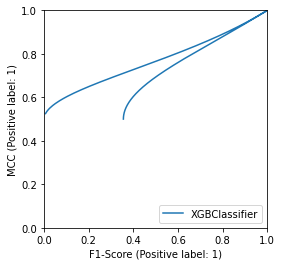

In [39]:
plot_mcc_f1_curve(xgb_twentyeight_day, X_test, y_twentyeight_day_pred)

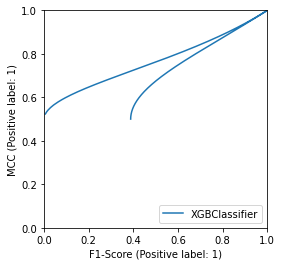

In [40]:
plot_mcc_f1_curve(xgb_sixty_day, X_test, y_sixty_day_pred)

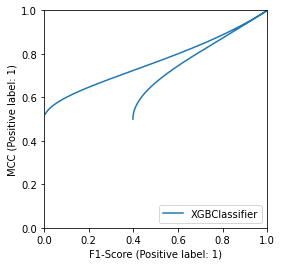

In [41]:
plot_mcc_f1_curve(xgb_ninety_day, X_test, y_ninety_day_pred)

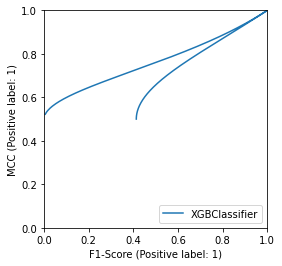

In [42]:
plot_mcc_f1_curve(xgb_onetwenty_day, X_test, y_onetwenty_day_pred)

#### Prediction probability distribution

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


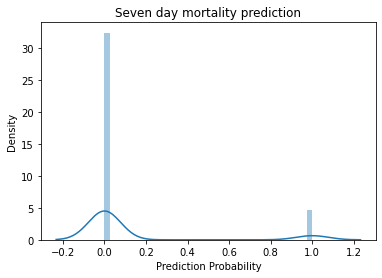

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


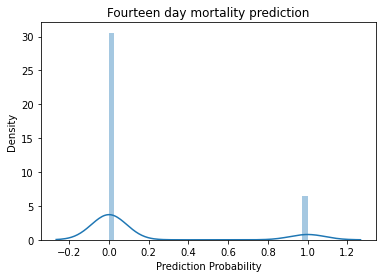

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


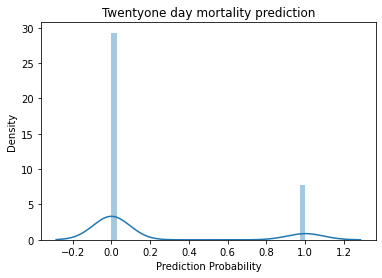

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


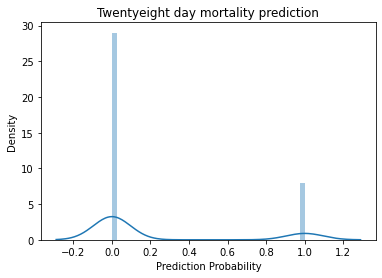

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


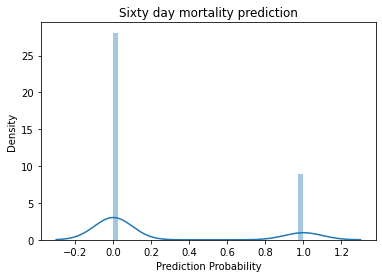

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


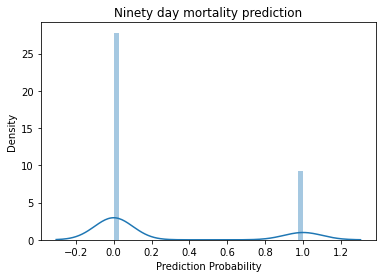

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


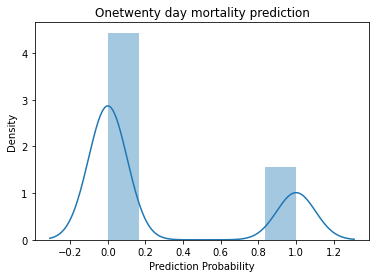

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

for (pred, label) in [
        (y_seven_day_pred, 'Seven day mortality prediction')
        , (y_fourteen_day_pred, 'Fourteen day mortality prediction')
        , (y_twentyone_day_pred, 'Twentyone day mortality prediction')
        , (y_twentyeight_day_pred, 'Twentyeight day mortality prediction')
        , (y_sixty_day_pred, 'Sixty day mortality prediction')
        , (y_ninety_day_pred, 'Ninety day mortality prediction')
        , (y_onetwenty_day_pred, 'Onetwenty day mortality prediction')
    ]:
    sns.distplot(pred, hist=True, rug=False, axlabel='Prediction Probability')
    plt.title(label)
    plt.show()

## Benchmarking

In [88]:
benchmarkDataQuery = """
    select
    mor.micro_specimen_id
    , mor.person_id
    , case when (mor.seven_day_mortality = True) then 1 else 0 end as seven_day_mortality
    , case when (mor.fourteen_day_mortality = True) then 1 else 0 end as fourteen_day_mortality
    , case when (mor.twentyone_day_mortality = True) then 1 else 0 end as twentyone_day_mortality
    , case when (mor.twentyeight_day_mortality = True) then 1 else 0 end as twentyeight_day_mortality
    , case when (mor.sixty_day_mortality = True) then 1 else 0 end as sixty_day_mortality
    , case when (mor.ninety_day_mortality = True) then 1 else 0 end as ninety_day_mortality
    , case when (mor.onetwenty_day_mortality = True) then 1 else 0 end as onetwenty_day_mortality
    , sap.sapsii
    , sap.sapsii_prob
    from
    sepsis_micro.mortality mor
    inner join sepsis_micro.cohort coh
    on mor.micro_specimen_id = coh.micro_specimen_id
    inner join omop_cdm.person per
    on per.person_id = coh.person_id
    inner join mimiciv.patients pat
    on pat.subject_id = per.person_source_value::int
    inner join mimiciv.icustays icu
    on icu.subject_id = pat.subject_id and (coh.chart_time > (icu.intime - interval '2' day)) and (coh.chart_time < (icu.outtime + interval '2' day))
    inner join saps_ii.SAPSII sap
    on sap.stay_id = icu.stay_id
    ;
"""
benchmarkDataDf = pd.read_sql_query(benchmarkDataQuery, con)
benchmarkDataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,sapsii,sapsii_prob
0,4434759,892204370,0,0,0,0,1,1,1,21,0.041754
1,4926039,1192062955,0,0,0,0,0,0,0,17,0.025876
2,5302944,-2086157124,0,0,0,0,0,0,0,38,0.212560
3,1203417,1574178987,0,0,0,0,0,0,0,28,0.087706
4,7557189,1574178987,0,0,0,0,0,0,0,28,0.087706
...,...,...,...,...,...,...,...,...,...,...,...
10053,6557873,697543230,0,0,0,0,0,0,0,52,0.507019
10054,3768944,-548840452,0,1,1,1,1,1,1,45,0.347723
10055,6605625,727098078,0,0,0,0,0,0,0,17,0.025876
10056,6729116,727098078,0,0,0,0,0,0,0,17,0.025876


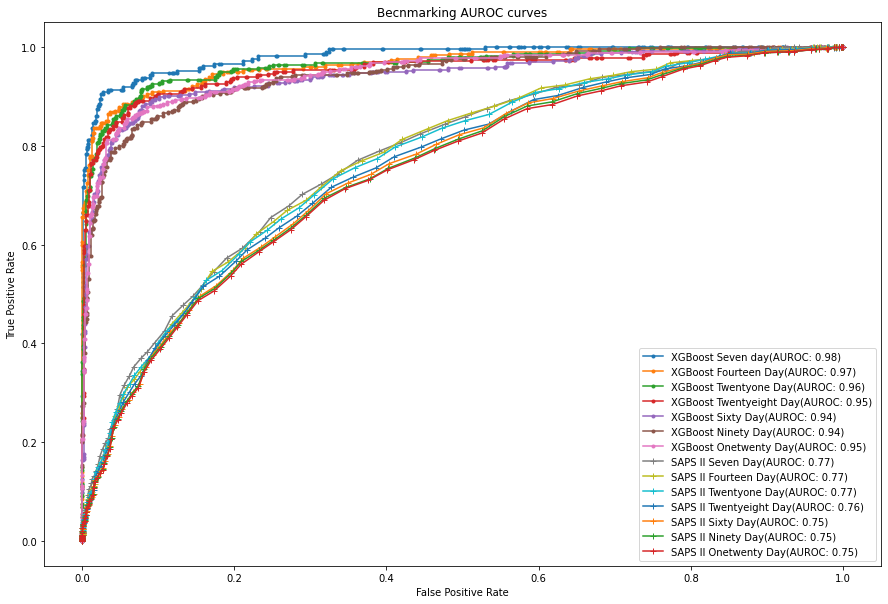

In [106]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label, saps) in [
        (y_seven_day_test, [p2 for p1, p2 in y_seven_day_prob], 'XGBoost Seven day', False)
        , (y_fourteen_day_test, [p2 for p1, p2 in y_fourteen_day_prob], 'XGBoost Fourteen Day', False)
        , (y_twentyone_day_test, [p2 for p1, p2 in y_twentyone_day_prob], 'XGBoost Twentyone Day', False)
        , (y_twentyeight_day_test, [p2 for p1, p2 in y_twentyeight_day_prob], 'XGBoost Twentyeight Day', False)
        , (y_sixty_day_test, [p2 for p1, p2 in y_sixty_day_prob], 'XGBoost Sixty Day', False)
        , (y_ninety_day_test, [p2 for p1, p2 in y_ninety_day_prob], 'XGBoost Ninety Day', False)
        , (y_onetwenty_day_test, [p2 for p1, p2 in y_onetwenty_day_prob], 'XGBoost Onetwenty Day', False)
        , (benchmarkDataDf.seven_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Seven Day', True)
        , (benchmarkDataDf.fourteen_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Fourteen Day', True)
        , (benchmarkDataDf.twentyone_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Twentyone Day', True)
        , (benchmarkDataDf.twentyeight_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Twentyeight Day', True)
        , (benchmarkDataDf.sixty_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Sixty Day', True)
        , (benchmarkDataDf.ninety_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Ninety Day', True)
        , (benchmarkDataDf.onetwenty_day_mortality, benchmarkDataDf.sapsii_prob, 'SAPS II Onetwenty Day', True)
    ]:
    fpr, tpr, _ = roc_curve(test, prob)
    if saps:
        marker = '+'
    else:
        marker = '.'
    plt.plot(fpr, tpr, marker=marker, label=label + '(AUROC: ' + str(round(roc_auc_score(test, prob), 2)) + ')')

# fpr, tpr, _ = roc_curve(benchmarkDataDf.seven_day_mortality, benchmarkDataDf.sapsii_prob)
# plt.plot(fpr, tpr, marker='.', label='SAPS II (AUROC: ' + str(round(roc_auc_score(benchmarkDataDf.seven_day_mortality, benchmarkDataDf.sapsii_prob), 2)) + ')')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# title
plt.title('Becnmarking AUROC curves')
# show the legend
plt.legend()
# show the plot
plt.show()